In [1]:
%pylab notebook
import lightkurve as lk
import astropy.units as u
from astropy.coordinates import SkyCoord
from lightkurve import search_lightcurve
from scipy import stats
from astropy.table import Table

Populating the interactive namespace from numpy and matplotlib


# Input star ID

In [2]:
APOGEE_ID = '2M19344461+4514189'

In [3]:
tb = Table.read('datafile1.fits')
n2mask = (tb['n'] ==2)&(tb['tess_variable'] =='d')
pok = ~tb['p'].mask
table_n2_pok = tb[pok & n2mask]

In [4]:
tb3 = Table.read('datafile3.fits')

In [5]:
#Displaying number of spectra taken for this star
star_row = table_n2_pok[table_n2_pok['objid']==APOGEE_ID]
nep = star_row['nep'].data[0]
tess_period = star_row['tess_period'].data[0]
print(f"{nep}, {tess_period}")

21, 4.359


#### Create SkyCoord coordinate object from 2MASS name

In [6]:
coords = SkyCoord.from_name(APOGEE_ID.replace('2M','2MASS J'))
print(f'{coords.ra.degree:0.4f}, {coords.dec.degree:+0.4f}')

293.6859, +45.2386


In [7]:
search_result = lk.search_lightcurve(coords)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 01,2009,Kepler,1800,kplr008957954,0.0
1,Kepler Quarter 02,2009,Kepler,1800,kplr008957954,0.0
2,Kepler Quarter 03,2009,Kepler,1800,kplr008957954,0.0
3,Kepler Quarter 04,2010,Kepler,1800,kplr008957954,0.0
4,Kepler Quarter 05,2010,Kepler,1800,kplr008957954,0.0
5,Kepler Quarter 06,2010,Kepler,1800,kplr008957954,0.0
6,Kepler Quarter 07,2010,Kepler,1800,kplr008957954,0.0
7,Kepler Quarter 08,2011,Kepler,1800,kplr008957954,0.0
8,Kepler Quarter 09,2011,Kepler,1800,kplr008957954,0.0


# Choices

In [38]:
#selecting the data
#'yes' if wanted; else 'anything'
author = 'QLP'
exptime = 600
#mission= '' must have a value
# remember to change to the number of objects you want cell 26

#you wanna stitch?
stitch ='yes'

#square root sampling per period?
#when period is half of sample rate 2
sqrtrule = 1

#what wrap phase you want? needs value
wrapphase = 0.8 # Only change if eclipse is spread accross the fold

#cleaning up the light curve. [start/end]_time_valid use to cut off bad edges. bad_data_[start/end] removes bad internal data.
#Use timesvalid if cutoff
#Numerical Values, use <None> (no <>) if not wanted
start_time_valid = None
end_time_valid = None
bad_data_start = None
bad_data_end = None

#flatten, careful removing noise
flatten= 'yes'
window_length=21 #Increase to make easier on lightcurve
sigma=3 #Increase to make easier on lightcurve
polyorder=2
break_tolerance=5
niters=5

In [39]:
#displaying all data for this star by this particular author
search_result = lk.search_lightcurve(coords,author=author,exptime=exptime)#,mission=mission)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 40,2021,QLP,600,270616245,0.0
1,TESS Sector 41,2021,QLP,600,270616245,0.0


#### Display all data for this star

In [40]:
#Displaying all data for this particular star from this author
if(stitch=='yes'):
    klc = search_result.download_all()
    klc = klc.stitch().normalize()
else:
    klc = search_result.download()
    klc = klc.normalize()
klc = klc.remove_nans()

<IPython.core.display.Javascript object>


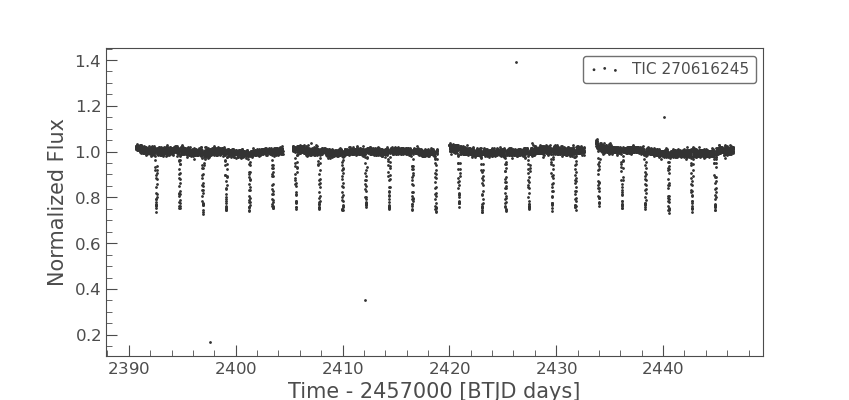

In [41]:
#plot of flux against BTJD days
klc.scatter();

<IPython.core.display.Javascript object>


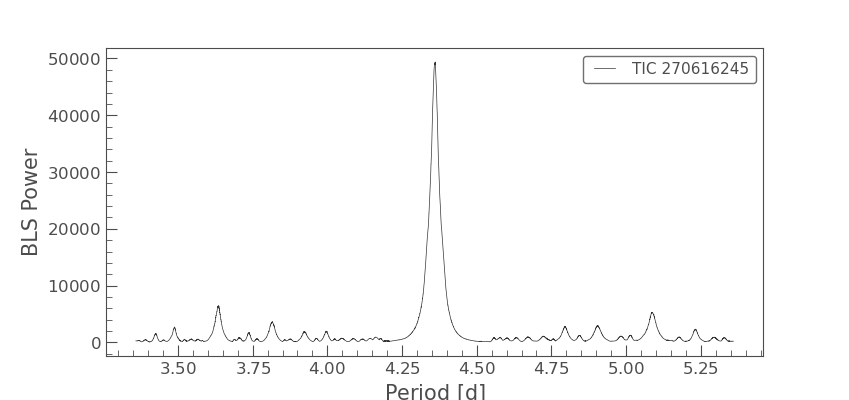

In [43]:
#displaying a bls plot of the binary system
period = np.linspace(tess_period-1,tess_period+1,10000)
bls = klc.to_periodogram(method='bls', period=period);
bls.plot();

# Period Calc
## Initial stuff

In [44]:
#displaying the period of the binary system
period = bls.period_at_max_power*sqrtrule
t0 = bls.transit_time_at_max_power
dur = bls.duration_at_max_power
period

<Quantity 4.36110021 d>

## Refining the Period

<IPython.core.display.Javascript object>


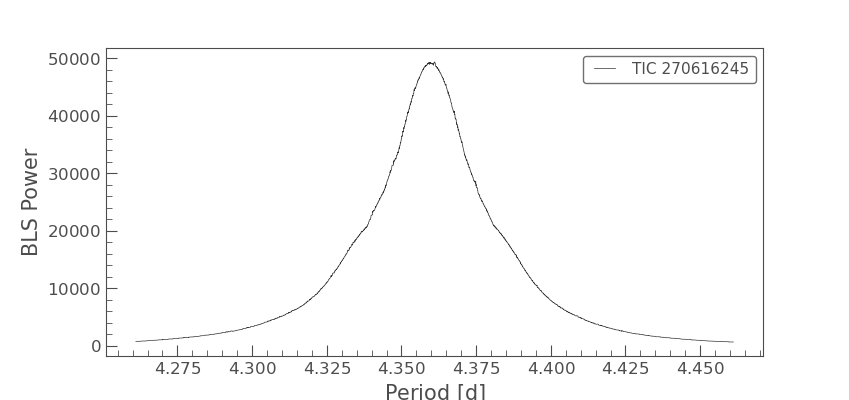

In [45]:
#displaying the refined period bls plot of the binary system
period = np.linspace(period.value-0.1,period.value+0.1,10000)
bls = klc.to_periodogram(method='bls', period=period);
bls.plot();

In [48]:
#displaying the refined period of the binary system
period_refined = bls.period_at_max_power
t0_refined = bls.transit_time_at_max_power
dur_refined = bls.duration_at_max_power

print(period_refined)
print(t0_refined)

4.360950195019502 d
2392.5483038820917


# Remove Foul Data
## Edges

In [49]:
if (start_time_valid!=None)&(end_time_valid!=None): 
    klc = klc.truncate(before=start_time_valid, after=end_time_valid, column='time');klc.scatter();

## Internals

In [50]:
if (bad_data_start!=None)&(bad_data_end!=None):
    if (start_time_valid!=None)&(end_time_valid!=None):
        good_data = ((klc.time.value<bad_data_start)|(klc.time.value>bad_data_end))&((klc.time.value>start_time_valid)&(klc.time.value<end_time_valid))
        klc = klc[good_data];klc.scatter();
    else:
        good_data = ((klc.time.value<bad_data_start)|(klc.time.value>bad_data_end))
        klc = klc[good_data];klc.scatter();

# Flattening

<IPython.core.display.Javascript object>


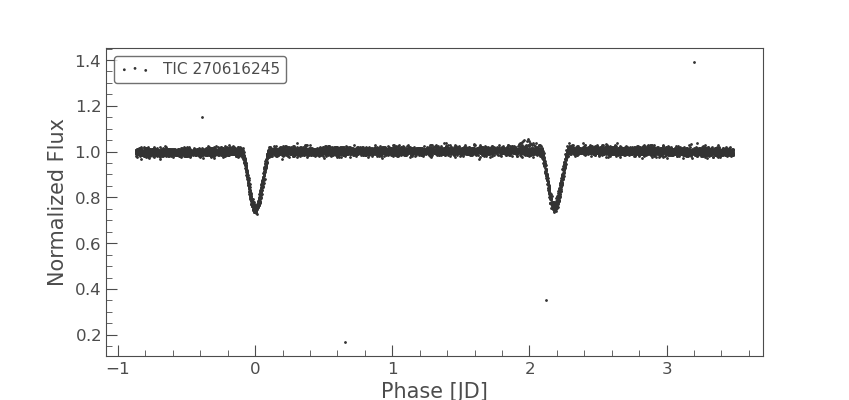

In [51]:
ax = klc.fold(period=period_refined, epoch_time=t0_refined,wrap_phase=wrapphase*period_refined).scatter()

# MUST INPUT CONTACT POINTS

In [52]:
primeclcon1 = -0.104 #Onset point for initial eclipse
primeclcon4 = 0.104  #Offset point for initial eclipse
sececlcon1 = 2.077   #Onset point for second eclipse
sececlcon4 = 2.291   #Offset point for second eclipse

In [53]:
primecllen = primeclcon4 - primeclcon1
sececllen = sececlcon4-sececlcon1
sececlcen = np.mean([sececlcon1,sececlcon4])

<IPython.core.display.Javascript object>


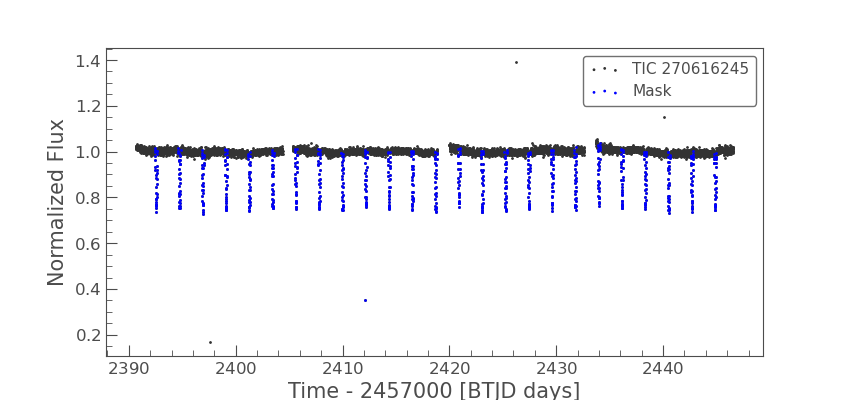

In [54]:
maska = klc.create_transit_mask(period = period_refined,duration = primecllen*u.day,transit_time=t0_refined)
maskb = klc.create_transit_mask(period = period_refined,duration = sececllen*u.day,transit_time=t0_refined+sececlcen*u.day)
mask = maska|maskb
ax = klc.scatter()
klc[mask].scatter(ax=ax,c='blue',label='Mask');

# Check the blue is only on the eclipses in above plot

<IPython.core.display.Javascript object>


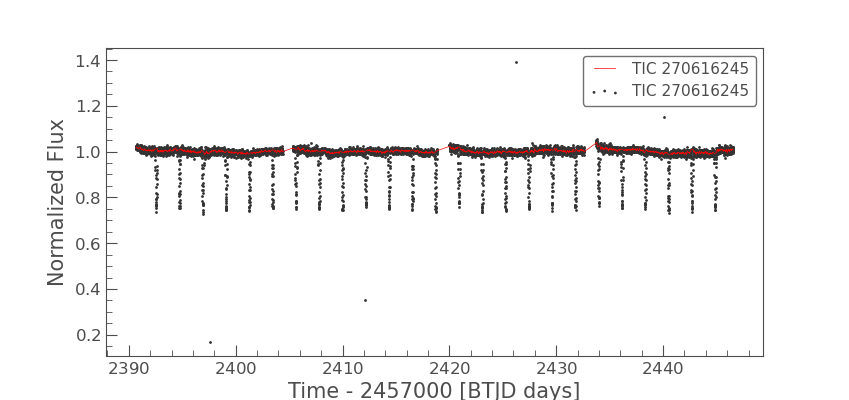

In [55]:
if(flatten=='yes'):
    lcflat,trend  = klc.flatten(window_length=window_length,polyorder=polyorder,return_trend=True,break_tolerance=break_tolerance,niters=niters,sigma=sigma,mask=mask)
    ax = klc.scatter()
    trend.plot(ax=ax,c='r');

# Flattened scatter of whole data set

<IPython.core.display.Javascript object>


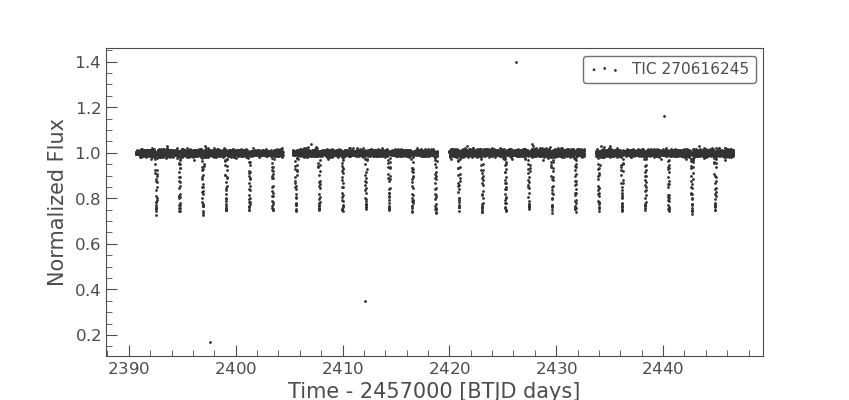

In [56]:
if(flatten!='yes'):
    lcflat = klc
ax=lcflat.scatter()

# Folded Lightcurve

<IPython.core.display.Javascript object>


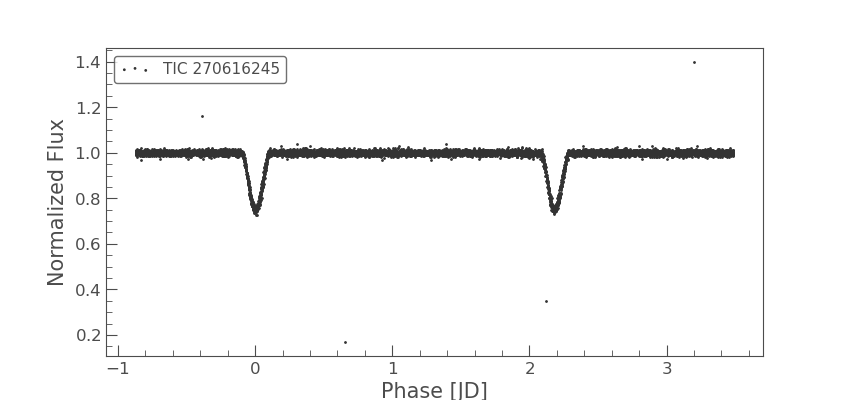

In [58]:
ax=lcflat.fold(period=period_refined,epoch_time=t0_refined,wrap_phase=wrapphase*period_refined).scatter()

# Calculation of Radii and Surface Brightness
## MUST EDIT TOP CELL FOR THIS TO WORK

In [59]:
Con4 = 0.1050 #Onset point or Offset point of the eclipse
Con3 = 0 #Onset or offset point of the total eclipse. If no flat base, put 0
Ideep = 0.751 #Flux value at the lowest point in the deeper eclipse
Ishal = 0.755 #Flux value at the lowest point in the shallower eclipse

### Print at the bottom is for everything needed for initial task 3

In [60]:
ph1 = abs(Con4)
ph2 = abs(Con3)
Iout = 1
P = period_refined.value
t1 = -ph1
t2 = -ph2
t3 = ph2
t4 = ph1
eps = (Iout-Ideep)/Ishal
d1 = (pi*(t4-t1))/P
d2 = (pi*(t3-t2))/P
rrat = np.sqrt(eps)
r1 = 0.5*np.sqrt(d1**2-d2**2)/eps**0.25
r2 = 0.5*(eps**0.25)*np.sqrt(d1**2-d2**2)
rsum = r1+r2
print(f'Sum of Radii = {rsum:.4f}, Ratio of Radii = {rrat:.4f}')
I1 = Ishal
S1 = I1/r1**2
I2 = Ideep - I1 + I1*eps
S2 = I2/r2**2
J = S2/S1
print(f'Ratio of Surface Brightness = {J:.4f}')
print(f'Period of System = {period_refined.value:.4f}, Reference Time = {t0_refined.value:.4f}')
print(APOGEE_ID)

Sum of Radii = 0.1571, Ratio of Radii = 0.5743
Ratio of Surface Brightness = 0.9839
Period of System = 4.3610, Reference Time = 2392.5483
2M19344461+4514189


<IPython.core.display.Javascript object>


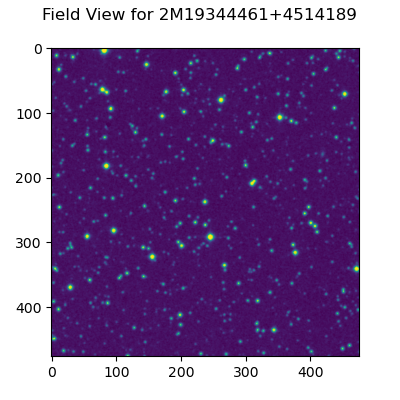

In [61]:
#displaying an image of the given star in the night sky
ra = klc.meta['RA']
dec = klc.meta['DEC']
size = 8  # Image size in arcminutes
survey = 'poss2ukstu_red'
url = f'https://archive.stsci.edu/cgi-bin/dss_search'
url += f'?v={survey}&r={ra}&d={dec}&e=J2000&h={size}&w={size}&f=gif&c=none&fov=NONE&v3='

fig2, ax = plt.subplots(figsize=(4,4))
import urllib.request
with urllib.request.urlopen(url) as f:
    gif = imread(f, format='GIF')
ax.imshow(gif);
fig2.suptitle(f'Field View for {APOGEE_ID}')
fig2.savefig(f'Field View for {APOGEE_ID}');

#### Lightcurve output to file

In [62]:
outtime = lcflat.time.value
outflux = lcflat.flux.value
outmag = -2.5*np.log10(outflux)
np.savetxt(APOGEE_ID+".lc",np.array([outtime,outmag]).T,fmt='%.6f')

In [63]:
n32mask = (tb3['objid'] ==APOGEE_ID)#&(tb['tess_variable']=='d')
table3_n2_pok = tb3[n32mask]
table3_n2_pok.show_in_notebook()

idx,objid,hjd,v1,e_v1,v2,e_v2,v3,e_v3,v4,e_v4
,,d,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s
0,2M19344461+4514189,58247.9635588,-40.4,3.7,-9.8,4.8,--,--,--,--
1,2M19344461+4514189,57672.601461,-21.28,0.92,--,--,--,--,--,--
2,2M19344461+4514189,57319.5832941,-9.9,4.1,-40.4,5.0,--,--,--,--
3,2M19344461+4514189,58291.767951,-24.1,0.87,--,--,--,--,--,--
4,2M19344461+4514189,57643.6048932,44.52,0.92,-92.69,0.85,--,--,--,--
5,2M19344461+4514189,57528.8975312,-3.3,2.1,-44.1,2.0,--,--,--,--
6,2M19344461+4514189,57496.9640491,-106.86,0.74,59.17,0.88,--,--,--,--
7,2M19344461+4514189,57178.8075994,-108.63,0.82,61.46,0.89,--,--,--,--
8,2M19344461+4514189,57174.8786489,-96.6,0.77,47.94,0.89,--,--,--,--


In [64]:
adjustedHJD= table3_n2_pok['hjd']-57000

np.savetxt(APOGEE_ID+"_s1.rv",np.array([adjustedHJD,table3_n2_pok['v1'],table3_n2_pok['e_v1']]).T,fmt='%.6f')
np.savetxt(APOGEE_ID+"_s2.rv",np.array([adjustedHJD,table3_n2_pok['v2'],table3_n2_pok['e_v2']]).T,fmt='%.6f')